# Cluster Analysis

## Imports, Functions, & Settings

In [384]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from glob import glob
from zipfile import ZipFile
import shutil

# Clustering
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

# Imputing missing values
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

import re

import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE

# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [215]:
# Function to remove outliers based on IQR method
def remove_outliers(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Define outlier bounds (1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df_no_outliers = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
    
    return df_no_outliers


In [216]:
def plot_healthy_mci_dementia_kmeans_knn_dbscan(fALFF_DMN_df_scaled, eps):
    """
    This function will attempt to find 3 clusters in the input df.
    The clusters correspond to healthy, mci, and demented levels 
    of cognition.

    Parameters
    ----------
    fALFF_DMN_df_scaled : pandas dataframe
        This is the pandas dataframe containing scaled data to be plot.
    """
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(fALFF_DMN_df_scaled)
    pred_label = kmeans.predict(fALFF_DMN_df_scaled)
    score = silhouette_score(fALFF_DMN_df_scaled, kmeans.labels_, random_state=42)
    print("Silhouette Score:", score)
    print(f"Predicted Labels: {pred_label}")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(fALFF_DMN_df_scaled)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
    plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
    plt.show()

    # Find distances to the k-th nearest neighbor (here k = min_samples)
    min_samples = 10  # minimum number of points required to form a cluster
    k = min_samples
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_pca)
    distances, indices = neighbors_fit.kneighbors(X_pca)


    # Sort the distances for plotting
    distances = np.sort(distances[:, k-1], axis=0)

    # Plot the k-distance graph
    plt.plot(distances)
    plt.title('K-Distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}-th nearest neighbor')
    # Find the optimal eps by identifying the elbow point
    # The elbow can be detected by finding the point where the distance starts to increase rapidly
    # We'll find the "elbow" by looking for the maximum change in slope
    gradient = np.diff(distances)  # Calculate the differences between consecutive distances
    second_derivative = np.diff(gradient)  # Second derivative approximates the curvature
    optimal_eps_index = np.argmax(second_derivative) + 1  # Find the index where second derivative is maximal

    # Optimal eps is the distance at this index
    optimal_eps = distances[optimal_eps_index]

    # Plot horizontal line at the optimal eps value
    plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
    plt.legend()
    plt.show()
    print(f'Optimal eps (elbow point): {optimal_eps:.2f}')

    dbscan = DBSCAN(eps=eps, min_samples=3)  # Adjust eps and min_samples
    labels = dbscan.fit_predict(fALFF_DMN_df_scaled)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title("DBSCAN Clusters (PCA Reduced Data)")
    plt.show()

## Data Loading

In [217]:
df_dir = "../data/dataframes/"

In [229]:
# Extract the BOLD signal data
with ZipFile(df_dir + "BOLD.zip") as zfile:
    zfile.extractall(df_dir)
BOLD_csv_l = glob(df_dir + "BOLD/" + "*.csv", recursive=True)
BOLD_df_l = []
for csv in BOLD_csv_l:
    BOLD_df_l.append(pd.read_csv(csv))
shutil.rmtree(df_dir + "BOLD")

In [230]:
# Load fALFF, CV, & subject names
fALFF_df = pd.read_csv(df_dir + "fALFF.csv", index_col=0)
cv_df = pd.read_csv(df_dir + "cv_df.csv", index_col=0)
p_df = pd.read_csv(df_dir + "participant_imputed_cleaned_master_df.csv")

### Viewing DataFrames

In [231]:
p_df.head()

,participant_id,age,sex,handedness,years_of_education,attention,executive,global,language,memory,visuospatial,moca_total,drs,tmt_a,tmt_b,bta,sdmt_oral,bnt,cvlt15,cvlt_ld_tot,fas,jlo
0,sub-0202,76.9260273972603,1,3,16,0.74333,0.08219,-0.12135,0.58319,-1.26360,-0.181613,23.0,133.0,27.82,159.49,19.0,38.0,59.0,17.0,1.0,39.0,25.0
1,sub-0203,73.3257654016019,1,2,12,0.22898,-0.72817,0.25027,-0.24200,-0.66063,-0.377471,25.0,136.0,59.25,301.23,16.0,25.0,52.0,27.0,3.0,42.0,24.0
2,sub-0204,55.0602739726027,1,3,14,0.18272,0.18931,0.41475,-0.36043,0.95818,-0.769186,26.0,137.0,51.38,161.55,14.0,44.0,56.0,43.0,12.0,20.0,22.0
3,sub-0205,77.43231529306091,1,3,16,0.35645,0.12266,0.29293,-0.25917,0.61895,-2.923620,25.0,137.0,34.50,144.40,14.0,37.0,57.0,37.0,11.0,19.0,11.0
4,sub-0206,72.0191780821918,1,3,12,0.30705,0.00481,-0.15784,-1.18563,0.46936,0.601817,22.0,135.0,39.30,169.34,14.0,36.0,49.0,42.0,8.0,23.0,29.0


In [232]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   participant_id      58 non-null     object 
 1   age                 58 non-null     object 
 2   sex                 58 non-null     int64  
 3   handedness          58 non-null     int64  
 4   years_of_education  58 non-null     int64  
 5   attention           58 non-null     float64
 6   executive           58 non-null     float64
 7   global              58 non-null     float64
 8   language            58 non-null     float64
 9   memory              58 non-null     float64
 10  visuospatial        58 non-null     float64
 11  moca_total          58 non-null     float64
 12  drs                 58 non-null     float64
 13  tmt_a               58 non-null     float64
 14  tmt_b               58 non-null     float64
 15  bta                 58 non-null     float64
 16  sdmt_oral 

In [233]:
fALFF_df.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Middle Temporal Gyrus, temporooccipital part","Inferior Temporal Gyrus, anterior division","Inferior Temporal Gyrus, posterior division","Inferior Temporal Gyrus, temporooccipital part",Postcentral Gyrus,Superior Parietal Lobule,"Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,"Lateral Occipital Cortex, superior division","Lateral Occipital Cortex, inferior division",Intracalcarine Cortex,Frontal Medial Cortex,Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),Subcallosal Cortex,Paracingulate Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Precuneous Cortex,Cuneal Cortex,Frontal Orbital Cortex,"Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Lingual Gyrus,"Temporal Fusiform Cortex, anterior division","Temporal Fusiform Cortex, posterior division",Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,Left Accumbens,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sub-0270,0.011413,0.010983,0.010253,0.010471,0.011631,0.010933,0.011267,0.008058,0.008130,0.010452,0.008608,0.011179,0.010173,0.009645,0.011204,0.010418,0.012473,0.011192,0.011523,0.011439,0.011484,0.011764,0.011731,0.011986,0.010531,0.010776,0.011162,0.011030,0.009603,0.010583,0.013008,0.013116,0.010240,0.010136,0.009292,0.012077,0.009298,0.010711,0.009901,0.010865,0.011174,0.012060,0.011300,0.008561,0.008354,0.010251,0.010544,0.012181,0.012214,0.011434,0.009866,0.010389,0.010566,0.009246,0.009638,0.010167,0.011396,0.010460,0.009887,0.012502,0.012156,0.009588,0.011064,0.009658,0.010349,0.009297,0.008296,0.008801,0.010626,0.007642,0.007719
sub-0205,0.008063,0.008100,0.008432,0.008537,0.008519,0.008345,0.008678,0.007926,0.008483,0.008496,0.008455,0.008690,0.008299,0.008189,0.008571,0.008448,0.008706,0.008823,0.008619,0.008552,0.008523,0.008735,0.009022,0.008342,0.008170,0.008531,0.008000,0.007862,0.007986,0.008305,0.008571,0.008667,0.008371,0.008033,0.008072,0.008521,0.008162,0.007927,0.008181,0.008236,0.007957,0.008101,0.008097,0.008045,0.008055,0.008195,0.008139,0.009211,0.008274,0.008541,0.008027,0.008071,0.007852,0.008285,0.008469,0.008193,0.008394,0.008408,0.008421,0.007980,0.008252,0.007906,0.007987,0.007816,0.008021,0.008095,0.008172,0.009426,0.009352,0.008675,0.010451
sub-0231,0.010883,0.010724,0.013460,0.011124,0.011169,0.011045,0.013046,0.007863,0.010838,0.008925,0.007855,0.009183,0.011301,0.009216,0.010086,0.010457,0.012941,0.013211,0.011417,0.011975,0.012970,0.012257,0.009664,0.010737,0.009975,0.012223,0.010256,0.009935,0.010129,0.013082,0.013718,0.011965,0.009132,0.008176,0.010871,0.011656,0.007848,0.009542,0.011925,0.010355,0.008407,0.008033,0.010748,0.008134,0.008985,0.008344,0.011313,0.009478,0.012854,0.012531,0.007318,0.008815,0.010196,0.007502,0.006873,0.010909,0.009295,0.010136,0.011004,0.012944,0.012541,0.007646,0.009958,0.009135,0.009343,0.009173,0.008074,0.007594,0.006212,0.006561,0.003043
sub-0240,0.012848,0.011475,0.012581,0.012059,0.011521,0.010469,0.0

In [234]:
cv_df.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Middle Temporal Gyrus, temporooccipital part","Inferior Temporal Gyrus, anterior division","Inferior Temporal Gyrus, posterior division","Inferior Temporal Gyrus, temporooccipital part",Postcentral Gyrus,Superior Parietal Lobule,"Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,"Lateral Occipital Cortex, superior division","Lateral Occipital Cortex, inferior division",Intracalcarine Cortex,Frontal Medial Cortex,Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),Subcallosal Cortex,Paracingulate Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Precuneous Cortex,Cuneal Cortex,Frontal Orbital Cortex,"Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Lingual Gyrus,"Temporal Fusiform Cortex, anterior division","Temporal Fusiform Cortex, posterior division",Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,Left Accumbens,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sub-0270,0.007361,0.004123,0.003377,0.003526,0.004109,0.004509,0.003287,0.006441,0.004820,0.004280,0.004419,0.004064,0.003274,0.006637,0.023289,0.002681,0.003128,0.003030,0.003651,0.003341,0.003405,0.003407,0.003256,0.006404,0.010207,0.004152,0.018896,0.004214,0.006011,0.003620,0.004620,0.006391,0.013186,0.008473,0.008238,0.005414,0.008607,0.016572,0.003368,0.004858,0.007905,0.012376,0.010389,0.006184,0.004952,0.007042,0.008111,0.003641,0.003696,0.003346,0.007772,0.005279,0.008433,0.005587,0.004703,0.005635,0.005861,0.007641,0.005683,0.003499,0.003508,0.003367,0.005808,0.012133,0.007270,0.016889,0.013879,0.026816,0.071313,0.013934,0.024464
sub-0205,0.015797,0.018319,0.022378,0.019799,0.019887,0.016706,0.019045,0.018231,0.020285,0.016501,0.022724,0.020059,0.014376,0.024385,0.017563,0.015015,0.022428,0.025338,0.023224,0.020779,0.018675,0.023894,0.017549,0.018931,0.026105,0.025590,0.031608,0.026580,0.032405,0.018161,0.019031,0.022229,0.022047,0.024726,0.031985,0.025830,0.028161,0.019787,0.018196,0.010594,0.015293,0.016157,0.011824,0.020387,0.018963,0.017069,0.022839,0.031945,0.014901,0.020341,0.042187,0.043613,0.026066,0.023572,0.021388,0.032502,0.031593,0.022018,0.018009,0.023049,0.019843,0.049101,0.054028,0.060103,0.018755,0.014706,0.025465,0.028863,0.070590,0.052207,0.108072
sub-0231,0.004760,0.004682,0.006065,0.004987,0.006065,0.006556,0.006051,0.003977,0.005636,0.005841,0.004864,0.004539,0.005793,0.005592,0.007204,0.013779,0.015200,0.019120,0.011122,0.011497,0.009489,0.014866,0.007504,0.006581,0.016876,0.008330,0.004858,0.005920,0.007521,0.006620,0.010936,0.011459,0.004920,0.009755,0.005898,0.009298,0.006469,0.005819,0.007404,0.013649,0.008564,0.005672,0.005553,0.005316,0.006718,0.006501,0.022517,0.024640,0.005699,0.007125,0.004840,0.006288,0.008372,0.006108,0.009718,0.008037,0.005422,0.013288,0.009035,0.004963,0.005630,0.005002,0.006167,0.011677,0.002962,0.006408,0.005817,0.019217,0.017145,0.011508,0.032281
sub-0240,0.006936,0.007587,0.006876,0.006616,0.007496,0.006326,0.0

In [235]:
len(BOLD_df_l)

58

In [236]:
BOLD_df_l[0].head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Middle Temporal Gyrus, temporooccipital part","Inferior Temporal Gyrus, anterior division","Inferior Temporal Gyrus, posterior division","Inferior Temporal Gyrus, temporooccipital part",Postcentral Gyrus,Superior Parietal Lobule,"Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,"Lateral Occipital Cortex, superior division","Lateral Occipital Cortex, inferior division",Intracalcarine Cortex,Frontal Medial Cortex,Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),Subcallosal Cortex,Paracingulate Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Precuneous Cortex,Cuneal Cortex,Frontal Orbital Cortex,"Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Lingual Gyrus,"Temporal Fusiform Cortex, anterior division","Temporal Fusiform Cortex, posterior division",Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,Left Accumbens,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
0,862.873813,751.177083,1011.703911,849.768817,775.444444,770.004739,860.582633,644.083532,754.967391,762.090164,696.123077,708.307971,761.852381,680.297521,501.004587,746.240437,855.361582,860.095563,804.280488,812.057416,799.624490,857.758710,802.012346,731.966102,595.030928,948.955414,411.224806,945.463415,810.933628,677.585,756.791574,782.533333,513.781513,424.666667,578.500000,705.138211,626.333333,495.314286,692.112,739.268116,787.584906,717.644444,704.009804,771.375000,764.229167,743.236364,703.8125,944.024862,720.646998,808.780566,789.577778,628.645963,715.533333,574.344828,735.175676,524.631090,671.428571,742.2875,766.250000,692.445239,779.448363,772.621053,611.491803,828.279070,457.205882,393.333333,429.090909,429.000000,469.2,443.5,381.0
1,861.350746,749.666667,1004.910615,849.813620,772.894180,766.421801,857.542017,646.355609,755.815217,762.032787,696.100000,707.891304,760.409524,678.892562,501.064220,744.415301,852.316384,856.095563,799.530488,809.966507,798.326531,855.819355,801.376543,728.754237,594.195876,939.286624,410.255814,939.760163,807.371681,675.665,752.920177,781.103704,514.037815,426.933333,576.896552,699.207317,626.136364,494.921429,689.352,735.739130,783.188679,714.400000,702.578431,762.392857,755.479167,744.218182,702.4375,941.444751,719.039794,807.074528,782.622222,627.652174,713.988889,575.879310,731.202703,522.902552,669.233083,737.6625,764.015625,690.184419,776.482268,764.094737,608.286885,820.255814,456.750000,391.866667,428.477273,429.814815,475.4,452.0,385.0
2,862.317503,748.500000,1002.368715,850.172043,773.656085,766.218009,856.820728,646.563246,755.228261,758.368852,695.092308,707.090580,759.509524,676.702479,499.940367,746.289617,851.608286,854.941980,799.469512,810.483254,797.730612,856.277419,802.651235,730.466102,596.206186,936.987261,412.162791,939.788618,808.628319,673.930,754.133038,780.059259,515.962185,424.800000,574.982759,700.268293,624.424242,491.614286,687.128,737.152174,781.943396,713.933333,704.637255,756.928571,752.291667,744.036364,703.1875,941.052486,719.011321,807.540943,779.444444,627.801242,713.

## Participant Data Analysis

In [237]:
columns = p_df.columns

24.517241379310345

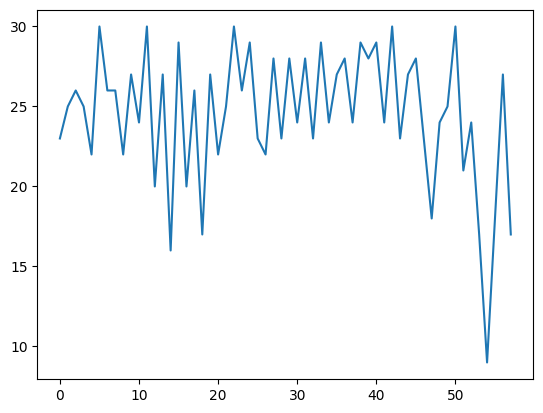

In [238]:
p_df["moca_total"].plot()
p_df["moca_total"].mean()

In [239]:
p_df["moca_total"].std()

4.26014322842305

<Axes: >

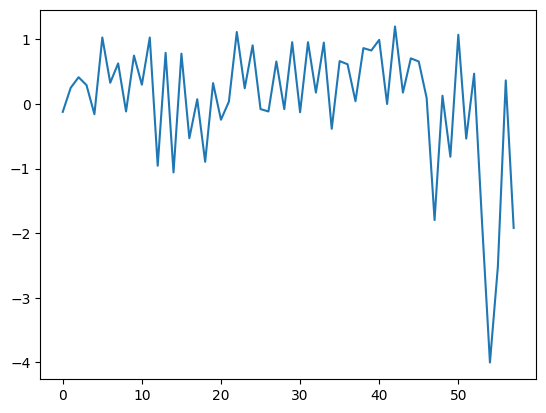

In [240]:
p_df["global"].plot()

In [241]:
p_df["global"].mean()

0.06199206896551724

In [242]:
p_df["global"].std()

0.9756984564713406

## Finding Clusters

In [243]:
# Drop non-numeric and irrelevant columns if any
df = p_df.select_dtypes(include=[np.number])
df = df.drop(columns=['sex', 'years_of_education'])
# df = df.select_dtypes(include=[np.number])  

In [244]:
df.describe()

,handedness,attention,executive,global,language,memory,visuospatial,moca_total,drs,tmt_a,tmt_b,bta,sdmt_oral,bnt,cvlt15,cvlt_ld_tot,fas,jlo
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.00000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,2.827586,-0.010481,0.029478,0.061992,0.059817,0.025741,-0.060047,24.517241,132.965517,56.26500,159.806724,11.741379,35.310345,55.913793,34.500000,6.568966,34.758621,25.620690
std,0.424592,1.060128,1.022696,0.975698,0.868535,1.023244,1.024348,4.260143,12.273156,53.96463,128.440353,8.323630,27.764174,3.840159,13.701389,4.702042,16.895250,5.230067
min,1.000000,-6.506410,-5.535500,-4.002680,-3.631330,-3.079390,-2.923620,9.000000,82.000000,21.98000,48.000000,-34.000000,-119.000000,43.000000,-8.000000,-7.000000,-35.000000,11.000000
25%,3.000000,-0.172655,-0.198617,-0.125992,-0.360430,-0.595042,-0.573329,23.000000,132.000000,32.51000,82.167500,9.250000,32.000000,55.000000,27.000000,4.000000,21.500000,23.000000
50%,3.000000,0.213240,0.183960,0.247175,0.271855,0.111260,0.210102,25.000000,136.000000,41.88500,118.490000,14.000000,38.500000,57.000000,36.500000,7.000000,37.500000,27.000000
75%,3.000000,0.491615,0.629400,0.739222,0.635130,0.676142,0.601817,28.000000,140.000000,61.75000,194.557500,16.000000,49.750000,58.750000,43.000000,10.000000,46.000000,29.000000
max,3.000000,0.856570,1.033480,1.200650,1.295190,1.939500,1.581105,30.000000,144.000000,402.00000,818.760000,20.000000,69.000000,60.000000,69.000000,14.000000,63.000000,34.000000


### Normalizing the Data

In [245]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [246]:
scaled_data_df = pd.DataFrame(scaled_data)

### Checking for Missing Values

In [247]:
scaled_data_df.isnull().values.any()

False

### Impute Missing Values

In [248]:
train_split = round(len(scaled_data_df) * .8)

In [249]:
train_split

46

In [250]:
# Split data before imputation
train, test = train_test_split(scaled_data_df, test_size=0.2, random_state=42)

In [ ]:
# Defining the pipeline
pipe = Pipeline([('imputer', KNNImputer())])

In [ ]:
# Defining the param_grid 
param_grid = {'imputer__n_neighbors': range(2, 11)}

In [ ]:
# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
# Fit on Training Data
grid.fit(train)

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_par

GridSearchCV(cv=5, estimator=Pipeline(steps=[('imputer', KNNImputer())]),
             param_grid={'imputer__n_neighbors': range(2, 11)},
             scoring='neg_mean_absolute_error')

In [ ]:
# Best n neighbors
best_n = grid.best_params_['imputer__n_neighbors']
print(f"Best n neighbors: {best_n}")

Best n neighbors: 2


### Imputing the Missing Values

In [ ]:
# Impute using best model
best_imputer = KNNImputer(n_neighbors=best_n)

In [ ]:
scaled_data_df_imputed = pd.DataFrame(best_imputer.fit_transform(scaled_data_df))

<Axes: >

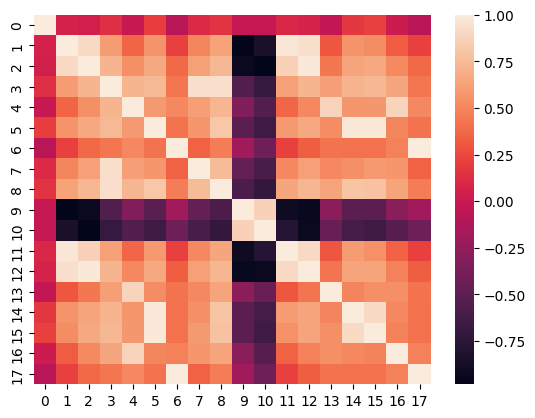

In [258]:
sns.heatmap(scaled_data_df.corr())

<Axes: >

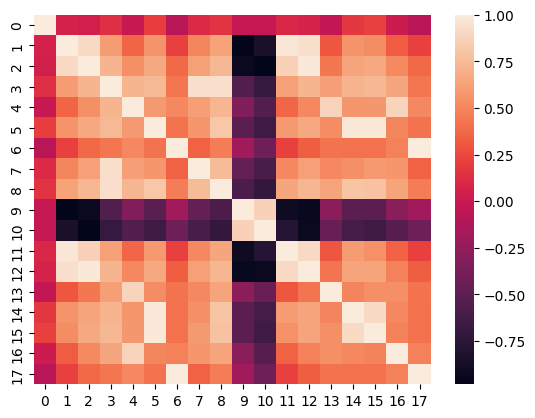

In [259]:
sns.heatmap(scaled_data_df_imputed.corr())

<Axes: >

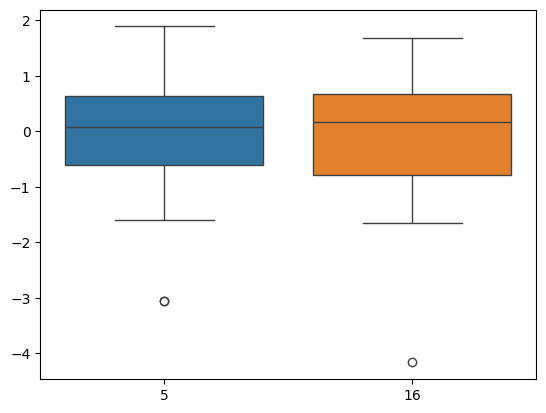

In [260]:
sns.boxplot(scaled_data_df[[5, 16]])

<Axes: >

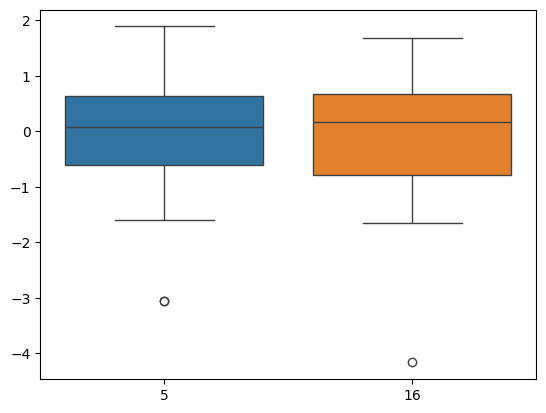

In [261]:
sns.boxplot(scaled_data_df_imputed[[5, 16]])

### Cleaning & Saving Imputed Dataform

In [262]:
unscaled_data = scaler.inverse_transform(scaled_data_df_imputed)

In [263]:
missing_columns = [c for c in p_df.columns if c not in df.columns]

In [264]:
unscaled_data_imputed_df = pd.DataFrame(unscaled_data, columns=df.columns)

In [265]:
p_imputed_df = pd.concat([p_df[missing_columns], unscaled_data_imputed_df], axis=1)

In [266]:
missing_columns

['participant_id', 'age', 'sex', 'years_of_education']

In [ ]:
p_imputed_df["handedness"] = np.array([int(re.sub(r'[^0-9.]', '',value)) for value in p_imputed_df["handedness"].values])

TypeError: cannot use a string pattern on a bytes-like object

In [ ]:
# p_df_imputed_cleaned = p_imputed_df

In [ ]:
# p_df_imputed_cleaned.to_csv("../data/dataframes/participant_imputed_cleaned_master_df.csv", index=False)

### Applying KMeans

In [269]:
scaled_df = pd.DataFrame(scaler.fit_transform(p_df.drop(missing_columns, axis=1)), columns=p_df.drop(missing_columns, axis=1).columns)

In [270]:
# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_df)

In [271]:
labels

array([0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0, 0], dtype=int32)

In [272]:
X = p_df["global"].values.reshape(-1, 1)

In [273]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)

KMeans(n_clusters=3)

In [274]:
score = silhouette_score(scaled_df, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.2603540142984622


### Maximizing Silhouette Score

<Axes: >

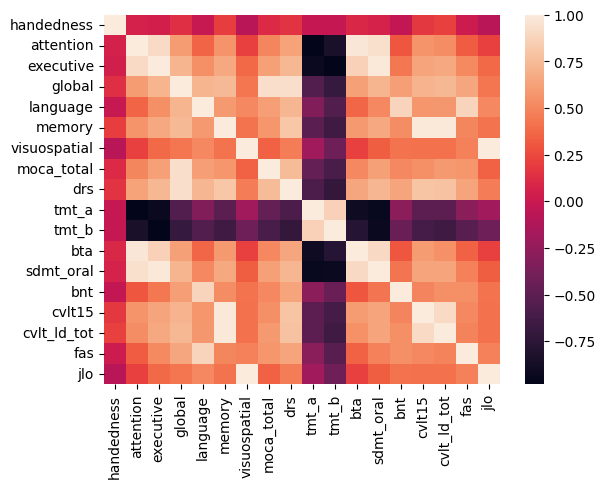

In [275]:
sns.heatmap(scaled_df.corr())

In [276]:
corr_columns_to_drop = ["executive", "attention", "memory", "global", "language", "visuospatial", "sdmt_oral", "cvlt_ld_tot"]

In [277]:
scaled_df_uncorrelated = scaled_df.drop(corr_columns_to_drop, axis=1)

<Axes: >

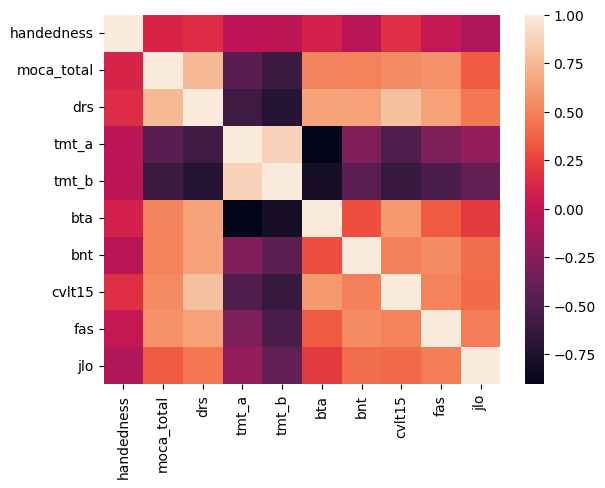

In [278]:
sns.heatmap(scaled_df_uncorrelated.corr())

### Removing Outliers

In [279]:
scaled_df_uncorrelated_no_outliers = scaled_df_uncorrelated

In [280]:
scaled_df_uncorrelated_no_outliers = remove_outliers(scaled_df_uncorrelated)

Silhouette Score: 0.2169578028811362
Predicted Labels: [2 1 0 0 2 1 0 1 0 1 2 1 2 2 1 0 2 0 2 1 0 1 0 1 0 2 0 0 2 0 0 0 0 0 2 0 0
 1 1 0 1]


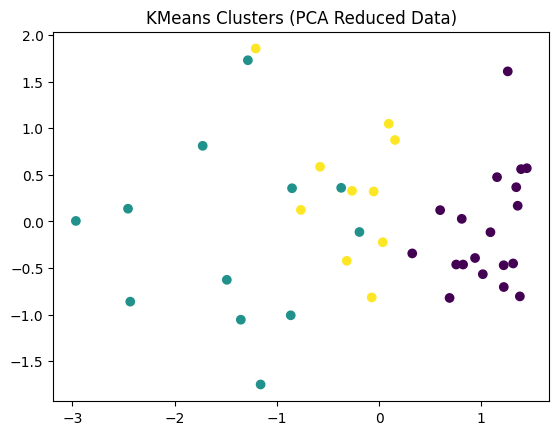

In [281]:
kmean = KMeans(n_clusters=3)
kmeans.fit(scaled_df_uncorrelated_no_outliers)
pred_label = kmeans.predict(scaled_df_uncorrelated_no_outliers)
score = silhouette_score(scaled_df_uncorrelated_no_outliers, kmeans.labels_, random_state=42)
print("Silhouette Score:", score)
print(f"Predicted Labels: {pred_label}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df_uncorrelated_no_outliers)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data)")
plt.show()

In [282]:
len(pred_label)

41

### kNN & DBSCAN

In [283]:
# Find distances to the k-th nearest neighbor (here k = min_samples)
min_samples = 10  # minimum number of points required to form a cluster
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

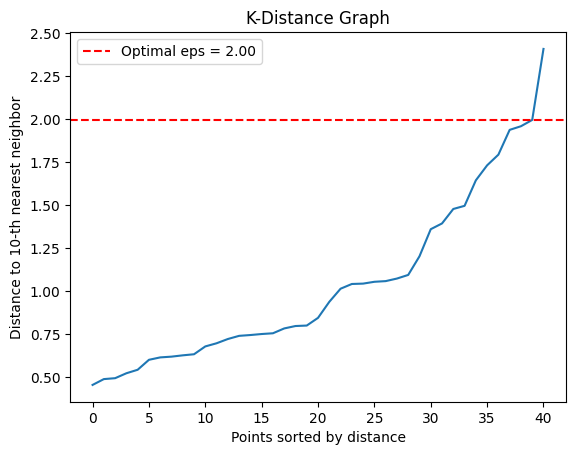

Optimal eps (elbow point): 2.00


In [284]:

# Sort the distances for plotting
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
# Find the optimal eps by identifying the elbow point
# The elbow can be detected by finding the point where the distance starts to increase rapidly
# We'll find the "elbow" by looking for the maximum change in slope
gradient = np.diff(distances)  # Calculate the differences between consecutive distances
second_derivative = np.diff(gradient)  # Second derivative approximates the curvature
optimal_eps_index = np.argmax(second_derivative) + 1  # Find the index where second derivative is maximal

# Optimal eps is the distance at this index
optimal_eps = distances[optimal_eps_index]

# Plot horizontal line at the optimal eps value
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.legend()
plt.show()
print(f'Optimal eps (elbow point): {optimal_eps:.2f}')

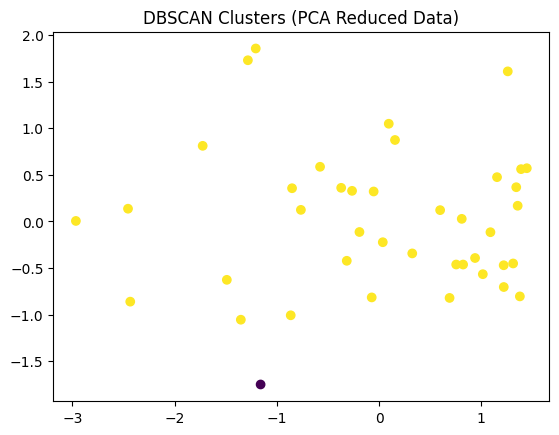

In [285]:


dbscan = DBSCAN(eps=optimal_eps, min_samples=3)  # Adjust eps and min_samples
labels = dbscan.fit_predict(scaled_df_uncorrelated_no_outliers)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN Clusters (PCA Reduced Data)")
plt.show()

## Examining Clusters Based on fALFF

In [286]:
fALFF_df.columns.values

array(['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus',
       'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part',
       'Postcentral Gyrus', 'Superior Parietal Lobule',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division',
       'Intracalcarine Cortex', 'Frontal Medial Corte

In [289]:
DMN = ['Frontal Pole', 'Precuneous Cortex', 'Angular Gyrus', 'Cingulate Gyrus, anterior division', 'Cingulate Gyrus, posterior division', 'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Frontal Orbital Cortex', 'Left Hippocampus', 'Right Hippocampus', 'Temporal Pole', 'Substantia Nigra Left', 'Substantia Nigra Right']

In [290]:
fALFF_df.loc[:, DMN].head()

,Frontal Pole,Precuneous Cortex,Angular Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division","Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Frontal Orbital Cortex,Left Hippocampus,Right Hippocampus,Temporal Pole,Substantia Nigra Left,Substantia Nigra Right
Subject,,,,,,,,,,,,,
sub-0270,0.011413,0.013008,0.011484,0.009603,0.010583,0.010136,0.009292,0.010240,0.011396,0.008296,0.008058,0.007719,0.007642
sub-0205,0.008063,0.008571,0.008523,0.007986,0.008305,0.008033,0.008072,0.008371,0.008394,0.008172,0.007926,0.010451,0.008675
sub-0231,0.010883,0.013718,0.012970,0.010129,0.013082,0.008176,0.010871,0.009132,0.009295,0.008074,0.007863,0.003043,0.006561
sub-0240,0.012848,0.013599,0.012254,0.006733,0.010845,0.010935,0.009403,0.009880,0.010489,0.008873,0.009404,0.005762,0.007185
sub-0238,0.010721,0.012405,0.011675,0.010422,0.010592,0.008161,0.010036,0.011226,0.008111,0.009224,0.007983,0.008760,0.007877


In [291]:
fALFF_df.columns.values

array(['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus',
       'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part',
       'Postcentral Gyrus', 'Superior Parietal Lobule',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division',
       'Intracalcarine Cortex', 'Frontal Medial Corte

<Axes: >

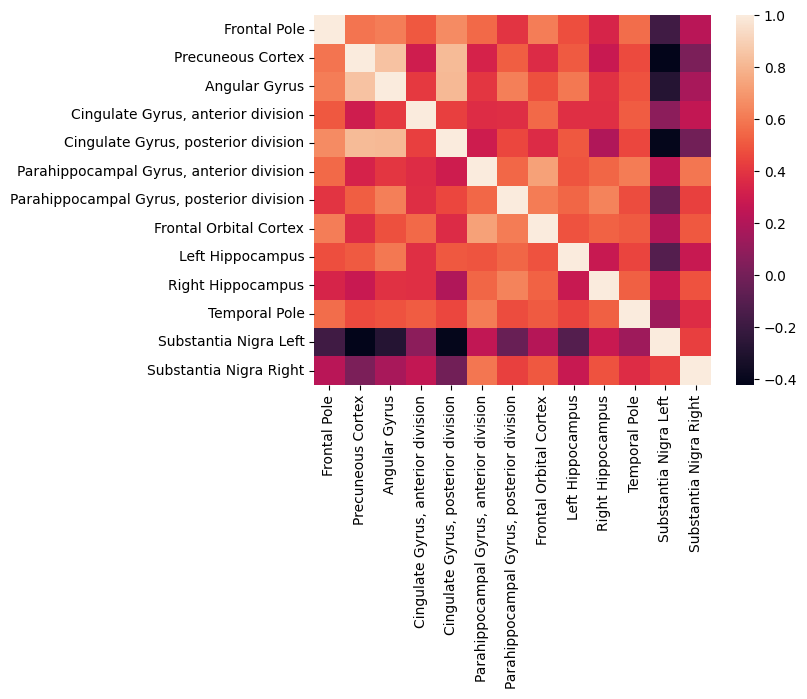

In [292]:
sns.heatmap(fALFF_df.loc[:, DMN].corr())

In [294]:
fALFF_DMN_df_scaled = pd.DataFrame(scaler.fit_transform(fALFF_df.loc[:, DMN]), columns=fALFF_df.loc[:, DMN].columns)
# cv_df

In [297]:
fALFF_DMN_df_scaled

,Frontal Pole,Precuneous Cortex,Angular Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division","Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Frontal Orbital Cortex,Left Hippocampus,Right Hippocampus,Temporal Pole,Substantia Nigra Left,Substantia Nigra Right
0,0.811700,0.819103,0.659495,0.630181,0.055431,0.945793,0.199392,0.470730,1.693261,-0.061089,-0.941409,0.214390,-0.009171
1,-1.342252,-1.518283,-1.275732,-0.395343,-1.335570,-0.449906,-0.544650,-0.697989,-0.601961,-0.146203,-1.036011,2.263043,0.749060
2,0.470915,1.193034,1.630584,0.963693,1.581531,-0.355003,1.162132,-0.222098,0.087053,-0.213346,-1.080837,-3.292112,-0.803165
3,1.733677,1.130336,1.162603,-1.190314,0.215615,1.475730,0.267087,0.245335,0.999733,0.334356,0.018574,-1.252980,-0.344870
4,0.366698,0.501363,0.784422,1.149375,0.061261,-0.365087,0.653228,1.087056,-0.818987,0.574519,-0.994939,0.994808,0.163341
5,0.580782,-0.445765,0.188211,-1.257342,0.581087,0.678069,-0.118521,0.457017,-0.353536,0.112932,-0.992429,1.050557,1.332500
6,-1.175119,0.440440,0.202960,-0.386295,0.616076,0.808106,0.846094,0.191105,0.326605,0.466059,0.306156,0.695332,0.259502
7,0.535837,0.678393,1.769474,2.685657,1.265840,-0.108793,0.803644,1.128455,-0.405929,2.221081,1.337421,1.128997,-0.744511
8,0.875781,-0.006360,-0.735999,0.844090,-0.347990,-0.481672,-0.905805,0.909845,0.175011,-0.070627,1.308367,-0.704379,-1.096869
9,1.045664,0.596846,0.383839,0.571705,0.978559,0.196322,-1.457051,0.434035,-1.270317,-1.858340,-0.229540,-0.845030,-0.425181


In [299]:
cv_df.isna().any()

Frontal Pole                                 False
Insular Cortex                               False
Superior Frontal Gyrus                       False
Middle Frontal Gyrus                         False
Inferior Frontal Gyrus, pars triangularis    False
                                             ...  
Right Hippocampus                            False
Right Amygdala                               False
Right Accumbens                              False
Substantia Nigra Right                       False
Substantia Nigra Left                         True
Length: 71, dtype: bool

### Imputing Missing Values in fALFF

In [ ]:
scaler = StandardScaler()

In [372]:
fALFF_df_scaled = scaler.fit_transform(fALFF_df)

In [388]:
# Split data before imputation
# train, test = train_test_split(fALFF_DMN_df_scaled, test_size=0.2, random_state=42)
train = fALFF_df_scaled[:train_split, :]
test = fALFF_df_scaled[train_split:, :]

# Defining the pipeline
pipe = Pipeline([('imputer', KNNImputer())])

# Defining the param_grid 
param_grid = {'imputer__n_neighbors': range(2, 11)}

# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit on Training Data
grid.fit(train)

# Best n neighbors
best_n = grid.best_params_['imputer__n_neighbors']
print(f"Best n neighbors: {best_n}")

# Impute using best model
best_imputer = KNNImputer(n_neighbors=best_n)
fALFF_df_scaled_imputed = pd.DataFrame(best_imputer.fit_transform(fALFF_df_scaled), columns=fALFF_df.columns)

Best n neighbors: 2


/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_par

In [374]:
fALFF_df_scaled_imputed.isna().any()

0     False
1     False
2     False
3     False
4     False
      ...  
66    False
67    False
68    False
69    False
70    False
Length: 71, dtype: bool

### Continuing Cluster Analysis

Silhouette Score: 0.21503191778455844
Predicted Labels: [0 1 0 0 0 0 0 2 0 0 2 2 2 1 1 1 0 0 0 2 1 1 2 1 1 0 1 0 1 2 1 2 1 2 1 1 0
 0 1 0 0 1 0 2 0 1 0 0 0 0 0 1 2 2 2 2 1 1]


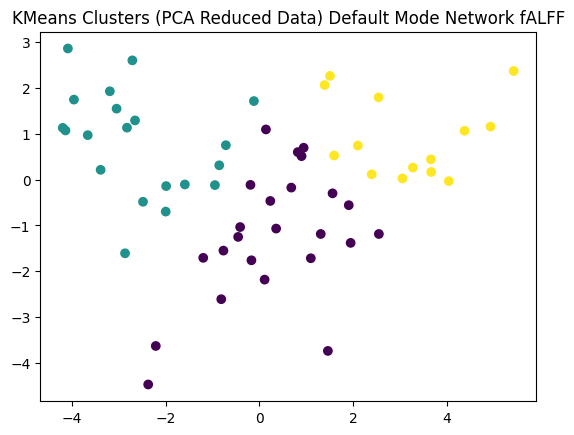

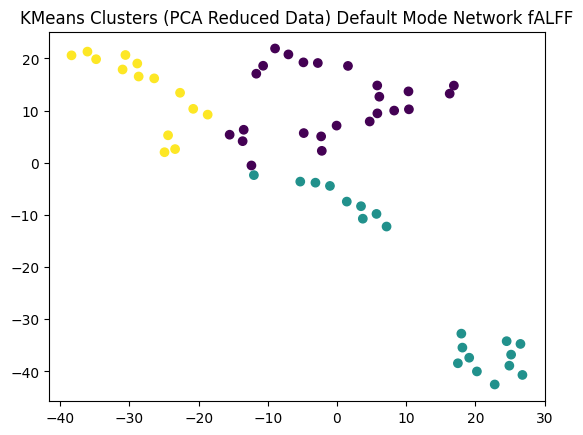

TSNE pred_label: [0 1 0 0 0 0 0 2 0 0 2 2 2 1 1 1 0 0 0 2 1 1 2 1 1 0 1 0 1 2 1 2 1 2 1 1 0
 0 1 0 0 1 0 2 0 1 0 0 0 0 0 1 2 2 2 2 1 1]


In [302]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(fALFF_DMN_df_scaled_imputed)
pred_label = kmeans.predict(fALFF_DMN_df_scaled_imputed)
score = silhouette_score(fALFF_DMN_df_scaled_imputed, kmeans.labels_, random_state=42)
print("Silhouette Score:", score)
print(f"Predicted Labels: {pred_label}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fALFF_DMN_df_scaled_imputed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
plt.show()

### TSNE
tsne = TSNE(perplexity=5)
X_pca_tsne = tsne.fit_transform(X_pca)

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
plt.show()

# print(f"PCA prev_pred_label: {prev_pred_label}\n")
print(f"TSNE pred_label: {pred_label}")



In [ ]:
# prev_pred_label = pred_label

In [303]:
p_df

,participant_id,age,sex,handedness,years_of_education,attention,executive,global,language,memory,visuospatial,moca_total,drs,tmt_a,tmt_b,bta,sdmt_oral,bnt,cvlt15,cvlt_ld_tot,fas,jlo
0,sub-0202,76.9260273972603,1,3,16,0.74333,0.08219,-0.12135,0.58319,-1.26360,-0.181613,23.0,133.0,27.82,159.49,19.0,38.0,59.0,17.0,1.0,39.0,25.0
1,sub-0203,73.3257654016019,1,2,12,0.22898,-0.72817,0.25027,-0.24200,-0.66063,-0.377471,25.0,136.0,59.25,301.23,16.0,25.0,52.0,27.0,3.0,42.0,24.0
2,sub-0204,55.0602739726027,1,3,14,0.18272,0.18931,0.41475,-0.36043,0.95818,-0.769186,26.0,137.0,51.38,161.55,14.0,44.0,56.0,43.0,12.0,20.0,22.0
3,sub-0205,77.43231529306091,1,3,16,0.35645,0.12266,0.29293,-0.25917,0.61895,-2.923620,25.0,137.0,34.50,144.40,14.0,37.0,57.0,37.0,11.0,19.0,11.0
4,sub-0206,72.0191780821918,1,3,12,0.30705,0.00481,-0.15784,-1.18563,0.46936,0.601817,22.0,135.0,39.30,169.34,14.0,36.0,49.0,42.0,8.0,23.0,29.0
5,sub-0207,67.2931506849315,1,3,19,0.62534,0.96298,1.02999,0.33756,0.43116,1.385247,30.0,140.0,26.92,58.23,17.0,63.0,56.0,38.0,9.0,44.0,33.0
6,sub-0209,73.8943334081892,0,3,16,0.45892,0.41552,0.32941,0.61332,0.58259,0.210102,26.0,135.0,43.09,99.50,17.0,43.0,57.0,45.0,8.0,49.0,27.0
7,sub-0210,55.208219178082196,0,2,16,0.61256,0.93263,0.62807,0.30847,0.61987,1.189390,26.0,142.0,21.98,56.19,16.0,61.0,56.0,43.0,9.0,43.0,32.0
8,sub-0212,80.36986301369859,1,3,16,-0.46109,-0.21207,-0.11517,0.91712,-0.36007,0.405959,22.0,136.0,70.66,175.60,7.0,26.0,60.0,26.0,6.0,46.0,28.0
9,sub-0213,72.09589041095892,1,3,18,0.37088,0.45054,0.74989,-0.37550,-0.02038,0.601817,27.0,142.0,39.28,85.79,15.0,42.0,57.0,35.0,6.0,15.0,29.0


In [109]:
len(pred_label)

58

Silhouette Score: 0.21813845696005105
Predicted Labels: [0 2 0 0 0 0 0 1 0 0 1 1 1 2 0 2 0 0 0 1 2 2 1 2 2 0 2 0 2 1 2 1 0 1 0 2 1
 0 2 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 2 2]


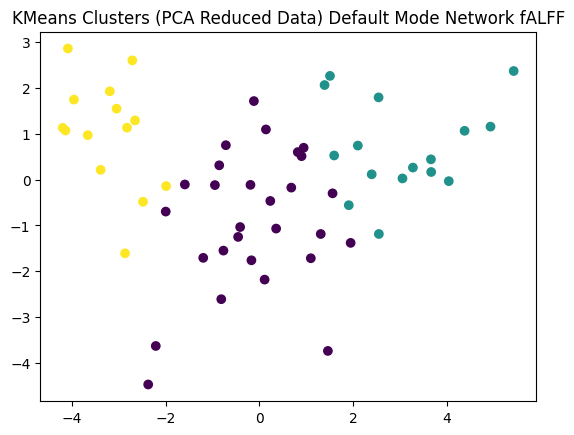

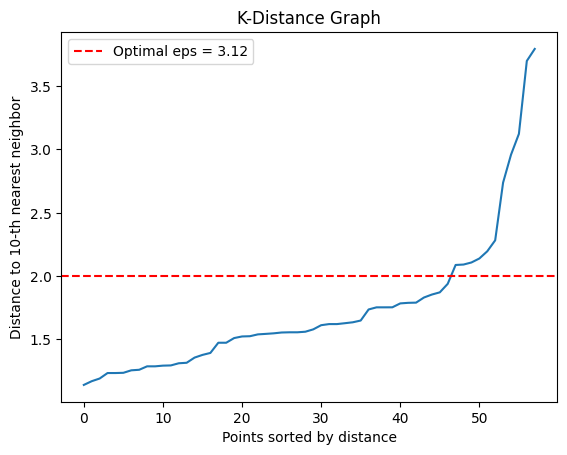

Optimal eps (elbow point): 3.12


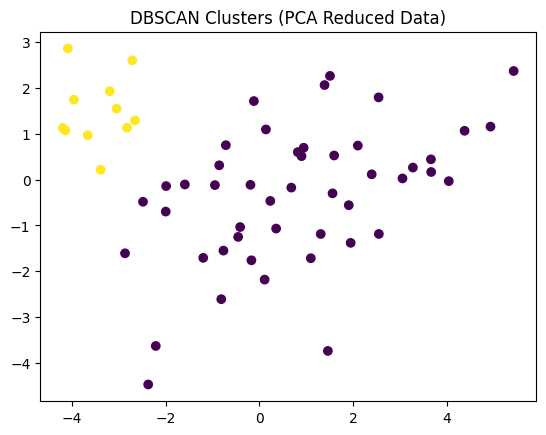

In [306]:

kmeans = KMeans(n_clusters=3)
kmeans.fit(fALFF_DMN_df_scaled_imputed)
pred_label = kmeans.predict(fALFF_DMN_df_scaled_imputed)
score = silhouette_score(fALFF_DMN_df_scaled_imputed, kmeans.labels_, random_state=42)
print("Silhouette Score:", score)
print(f"Predicted Labels: {pred_label}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fALFF_DMN_df_scaled_imputed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
plt.show()

# Find distances to the k-th nearest neighbor (here k = min_samples)
min_samples = 10  # minimum number of points required to form a cluster
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)


# Sort the distances for plotting
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
# Find the optimal eps by identifying the elbow point
# The elbow can be detected by finding the point where the distance starts to increase rapidly
# We'll find the "elbow" by looking for the maximum change in slope
gradient = np.diff(distances)  # Calculate the differences between consecutive distances
second_derivative = np.diff(gradient)  # Second derivative approximates the curvature
optimal_eps_index = np.argmax(second_derivative) + 1  # Find the index where second derivative is maximal

# Optimal eps is the distance at this index
optimal_eps = distances[optimal_eps_index]

# Plot horizontal line at the optimal eps value
plt.axhline(y=2.0, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.legend()
plt.show()
print(f'Optimal eps (elbow point): {optimal_eps:.2f}')

dbscan = DBSCAN(eps=2.0, min_samples=3)  # Adjust eps and min_samples
labels = dbscan.fit_predict(fALFF_DMN_df_scaled_imputed)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN Clusters (PCA Reduced Data)")
plt.show()

In [ ]:
# Predicted Labels from the Kmeans clusters of fALFF
predicted_labels_healthy_mci_dementia = [1 ,2 ,1 ,1 ,1 ,0 ,1 ,1 ,0 ,0 ,1 ,1 ,1 ,2 ,0 ,2 ,0 ,0 ,0 ,1 ,2 ,0 ,1 ,2 ,2 ,1 ,2 ,0 ,2 ,1 ,2 ,1 ,0 ,1 ,0 ,2 ,1
 ,0 ,0 ,1 ,1 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,2 ,0]

Silhouette Score: 0.21664997936691763
Predicted Labels: [0 1 0 0 0 0 0 2 0 0 2 2 2 1 0 1 0 0 0 2 1 1 2 1 1 0 1 0 1 2 1 2 0 0 0 1 0
 0 1 0 0 1 0 2 0 1 0 0 0 0 0 0 2 2 2 2 1 1]


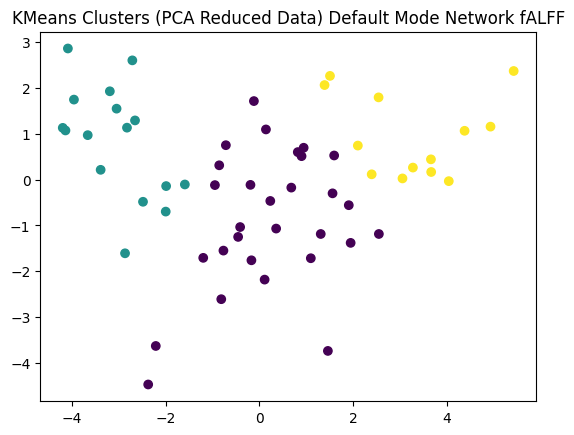

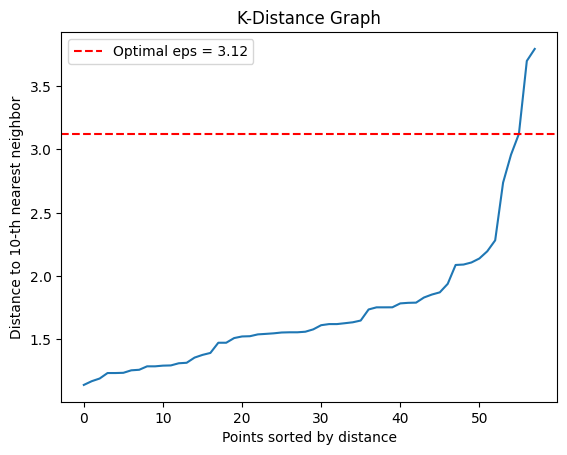

Optimal eps (elbow point): 3.12


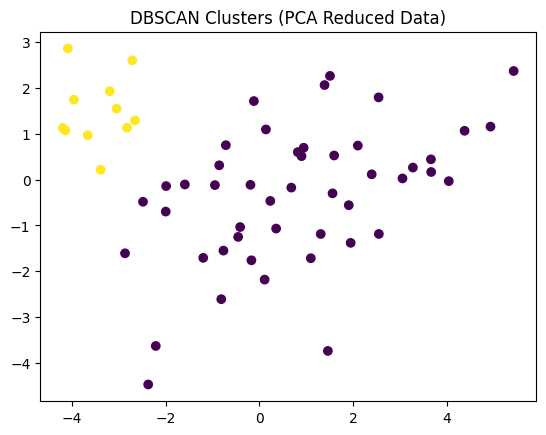

In [310]:
plot_healthy_mci_dementia_kmeans_knn_dbscan(fALFF_DMN_df_scaled_imputed, 2.0)

### Imputing missing values in cv

In [ ]:
cv_df_scaled = scaler.fit_transform(cv_df)

In [316]:
cv_df_scaled = pd.DataFrame(cv_df_scaled, columns=cv_df.columns)

In [325]:
train = cv_df_scaled.loc[:train_split, :]
test = cv_df_scaled.loc[train_split:, :]


In [334]:
# Split data before imputation
# train, test = train_test_split(cv_df_scaled, test_size=0.2, random_state=42)
# Defining the pipeline
pipe = Pipeline([('imputer', KNNImputer())])

# Defining the param_grid 
param_grid = {'imputer__n_neighbors': range(2, 11)}

# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit on Training Data
grid.fit(train)

# Best n neighbors
best_n = grid.best_params_['imputer__n_neighbors']
print(f"Best n neighbors: {best_n}")

# Impute using best model
best_imputer = KNNImputer(n_neighbors=best_n)
cv_df_scaled_imputed = pd.DataFrame(best_imputer.fit_transform(cv_df_scaled), columns=cv_df_scaled.columns)

Best n neighbors: 2


/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_par

In [337]:
cv_df_scaled_imputed.isna().any()

Frontal Pole                                 False
Insular Cortex                               False
Superior Frontal Gyrus                       False
Middle Frontal Gyrus                         False
Inferior Frontal Gyrus, pars triangularis    False
                                             ...  
Right Hippocampus                            False
Right Amygdala                               False
Right Accumbens                              False
Substantia Nigra Right                       False
Substantia Nigra Left                        False
Length: 71, dtype: bool

### Continuing Cluster Analysis

Silhouette Score: 0.3220772618702341
Predicted Labels: [0 1 0 0 0 2 0 0 0 0 2 2 0 1 0 1 0 0 0 2 1 0 0 1 0 0 1 0 1 2 1 0 2 0 0 1 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 0]


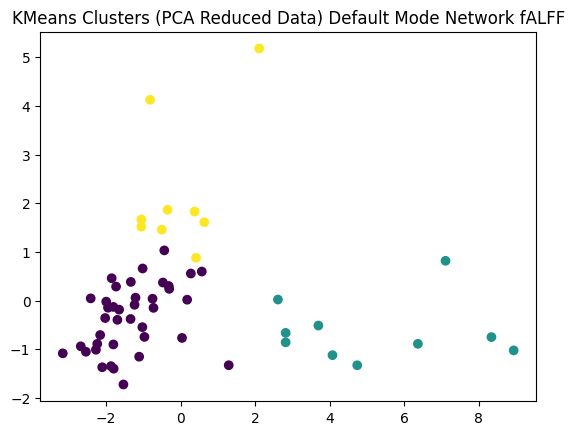

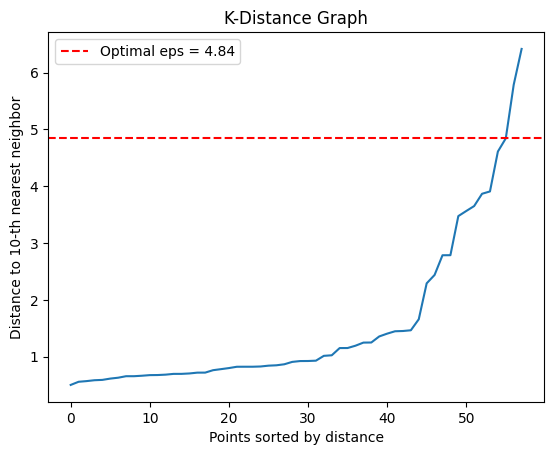

Optimal eps (elbow point): 4.84


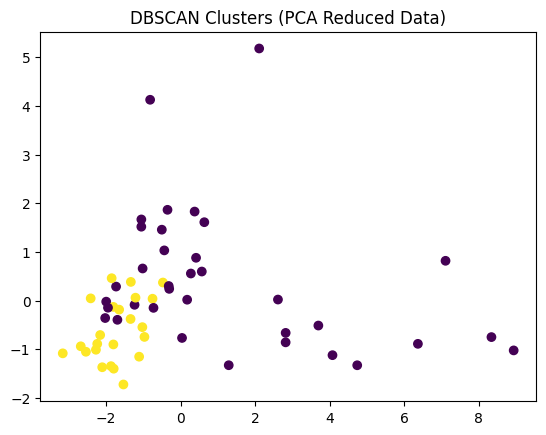

In [349]:
plot_healthy_mci_dementia_kmeans_knn_dbscan(scaler.fit_transform(cv_df_scaled_imputed.loc[:, DMN]), 1.5)

In [268]:
# Predicted Labels from the CV of the DMN
predicted_labels_cv_dmn = [0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,2 ,0 ,1 ,0 ,1 ,0 ,0 ,2 ,2 ,1 ,0 ,0 ,1 ,2 ,0 ,1 ,0 ,1 ,2 ,1 ,0 ,2 ,0 ,0 ,1 ,0
 ,0 ,0 ,0 ,2 ,2 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,2 ,2 ,1 ,0]

In [291]:
predicted_labels_healthy_mci_dementia.count(2)

11

In [290]:
predicted_labels_cv_dmn.count(2)

10

In [292]:
predicted_labels_healthy_mci_dementia

[1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 0]

In [293]:
predicted_labels_cv_dmn

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0]

In [ ]:
cv_df_scaled

In [389]:
scaler = StandardScaler()

In [362]:
scaler.fit(cv_df)

StandardScaler()

In [390]:
scaler.fit(fALFF_df)

StandardScaler()

In [369]:
fALFF_df.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Middle Temporal Gyrus, temporooccipital part","Inferior Temporal Gyrus, anterior division","Inferior Temporal Gyrus, posterior division","Inferior Temporal Gyrus, temporooccipital part",Postcentral Gyrus,Superior Parietal Lobule,"Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,"Lateral Occipital Cortex, superior division","Lateral Occipital Cortex, inferior division",Intracalcarine Cortex,Frontal Medial Cortex,Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),Subcallosal Cortex,Paracingulate Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Precuneous Cortex,Cuneal Cortex,Frontal Orbital Cortex,"Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Lingual Gyrus,"Temporal Fusiform Cortex, anterior division","Temporal Fusiform Cortex, posterior division",Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,Left Accumbens,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sub-0270,0.011413,0.010983,0.010253,0.010471,0.011631,0.010933,0.011267,0.008058,0.008130,0.010452,0.008608,0.011179,0.010173,0.009645,0.011204,0.010418,0.012473,0.011192,0.011523,0.011439,0.011484,0.011764,0.011731,0.011986,0.010531,0.010776,0.011162,0.011030,0.009603,0.010583,0.013008,0.013116,0.010240,0.010136,0.009292,0.012077,0.009298,0.010711,0.009901,0.010865,0.011174,0.012060,0.011300,0.008561,0.008354,0.010251,0.010544,0.012181,0.012214,0.011434,0.009866,0.010389,0.010566,0.009246,0.009638,0.010167,0.011396,0.010460,0.009887,0.012502,0.012156,0.009588,0.011064,0.009658,0.010349,0.009297,0.008296,0.008801,0.010626,0.007642,0.007719
sub-0205,0.008063,0.008100,0.008432,0.008537,0.008519,0.008345,0.008678,0.007926,0.008483,0.008496,0.008455,0.008690,0.008299,0.008189,0.008571,0.008448,0.008706,0.008823,0.008619,0.008552,0.008523,0.008735,0.009022,0.008342,0.008170,0.008531,0.008000,0.007862,0.007986,0.008305,0.008571,0.008667,0.008371,0.008033,0.008072,0.008521,0.008162,0.007927,0.008181,0.008236,0.007957,0.008101,0.008097,0.008045,0.008055,0.008195,0.008139,0.009211,0.008274,0.008541,0.008027,0.008071,0.007852,0.008285,0.008469,0.008193,0.008394,0.008408,0.008421,0.007980,0.008252,0.007906,0.007987,0.007816,0.008021,0.008095,0.008172,0.009426,0.009352,0.008675,0.010451
sub-0231,0.010883,0.010724,0.013460,0.011124,0.011169,0.011045,0.013046,0.007863,0.010838,0.008925,0.007855,0.009183,0.011301,0.009216,0.010086,0.010457,0.012941,0.013211,0.011417,0.011975,0.012970,0.012257,0.009664,0.010737,0.009975,0.012223,0.010256,0.009935,0.010129,0.013082,0.013718,0.011965,0.009132,0.008176,0.010871,0.011656,0.007848,0.009542,0.011925,0.010355,0.008407,0.008033,0.010748,0.008134,0.008985,0.008344,0.011313,0.009478,0.012854,0.012531,0.007318,0.008815,0.010196,0.007502,0.006873,0.010909,0.009295,0.010136,0.011004,0.012944,0.012541,0.007646,0.009958,0.009135,0.009343,0.009173,0.008074,0.007594,0.006212,0.006561,0.003043
sub-0240,0.012848,0.011475,0.012581,0.012059,0.011521,0.010469,0.0

In [371]:
fALFF_df.isna().any()

Frontal Pole                                 False
Insular Cortex                               False
Superior Frontal Gyrus                       False
Middle Frontal Gyrus                         False
Inferior Frontal Gyrus, pars triangularis    False
                                             ...  
Right Hippocampus                            False
Right Amygdala                               False
Right Accumbens                              False
Substantia Nigra Right                       False
Substantia Nigra Left                         True
Length: 71, dtype: bool

In [391]:
fALFF_df_imputed = pd.DataFrame(scaler.inverse_transform(fALFF_df_scaled_imputed), columns = fALFF_df.columns)

In [392]:
fALFF_df_imputed.isna().any()

Frontal Pole                                 False
Insular Cortex                               False
Superior Frontal Gyrus                       False
Middle Frontal Gyrus                         False
Inferior Frontal Gyrus, pars triangularis    False
                                             ...  
Right Hippocampus                            False
Right Amygdala                               False
Right Accumbens                              False
Substantia Nigra Right                       False
Substantia Nigra Left                        False
Length: 71, dtype: bool

In [393]:
fALFF_df_imputed.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Middle Temporal Gyrus, temporooccipital part","Inferior Temporal Gyrus, anterior division","Inferior Temporal Gyrus, posterior division","Inferior Temporal Gyrus, temporooccipital part",Postcentral Gyrus,Superior Parietal Lobule,"Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,"Lateral Occipital Cortex, superior division","Lateral Occipital Cortex, inferior division",Intracalcarine Cortex,Frontal Medial Cortex,Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),Subcallosal Cortex,Paracingulate Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Precuneous Cortex,Cuneal Cortex,Frontal Orbital Cortex,"Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Lingual Gyrus,"Temporal Fusiform Cortex, anterior division","Temporal Fusiform Cortex, posterior division",Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,Left Accumbens,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
0,0.011413,0.010983,0.010253,0.010471,0.011631,0.010933,0.011267,0.008058,0.008130,0.010452,0.008608,0.011179,0.010173,0.009645,0.011204,0.010418,0.012473,0.011192,0.011523,0.011439,0.011484,0.011764,0.011731,0.011986,0.010531,0.010776,0.011162,0.011030,0.009603,0.010583,0.013008,0.013116,0.010240,0.010136,0.009292,0.012077,0.009298,0.010711,0.009901,0.010865,0.011174,0.012060,0.011300,0.008561,0.008354,0.010251,0.010544,0.012181,0.012214,0.011434,0.009866,0.010389,0.010566,0.009246,0.009638,0.010167,0.011396,0.010460,0.009887,0.012502,0.012156,0.009588,0.011064,0.009658,0.010349,0.009297,0.008296,0.008801,0.010626,0.007642,0.007719
1,0.008063,0.008100,0.008432,0.008537,0.008519,0.008345,0.008678,0.007926,0.008483,0.008496,0.008455,0.008690,0.008299,0.008189,0.008571,0.008448,0.008706,0.008823,0.008619,0.008552,0.008523,0.008735,0.009022,0.008342,0.008170,0.008531,0.008000,0.007862,0.007986,0.008305,0.008571,0.008667,0.008371,0.008033,0.008072,0.008521,0.008162,0.007927,0.008181,0.008236,0.007957,0.008101,0.008097,0.008045,0.008055,0.008195,0.008139,0.009211,0.008274,0.008541,0.008027,0.008071,0.007852,0.008285,0.008469,0.008193,0.008394,0.008408,0.008421,0.007980,0.008252,0.007906,0.007987,0.007816,0.008021,0.008095,0.008172,0.009426,0.009352,0.008675,0.010451
2,0.010883,0.010724,0.013460,0.011124,0.011169,0.011045,0.013046,0.007863,0.010838,0.008925,0.007855,0.009183,0.011301,0.009216,0.010086,0.010457,0.012941,0.013211,0.011417,0.011975,0.012970,0.012257,0.009664,0.010737,0.009975,0.012223,0.010256,0.009935,0.010129,0.013082,0.013718,0.011965,0.009132,0.008176,0.010871,0.011656,0.007848,0.009542,0.011925,0.010355,0.008407,0.008033,0.010748,0.008134,0.008985,0.008344,0.011313,0.009478,0.012854,0.012531,0.007318,0.008815,0.010196,0.007502,0.006873,0.010909,0.009295,0.010136,0.011004,0.012944,0.012541,0.007646,0.009958,0.009135,0.009343,0.009173,0.008074,0.007594,0.006212,0.006561,0.003043
3,0.012848,0.011475,0.012581,0.012059,0.011521,0.010469,0.012200,0.009404,0.009567,0.009665,0.010210,0.012489,0.012155,0.009388,0.009679,0.011027,0.011714,0.011636,0.

In [394]:
cv_df_imputed.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Middle Temporal Gyrus, temporooccipital part","Inferior Temporal Gyrus, anterior division","Inferior Temporal Gyrus, posterior division","Inferior Temporal Gyrus, temporooccipital part",Postcentral Gyrus,Superior Parietal Lobule,"Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,"Lateral Occipital Cortex, superior division","Lateral Occipital Cortex, inferior division",Intracalcarine Cortex,Frontal Medial Cortex,Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex),Subcallosal Cortex,Paracingulate Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Precuneous Cortex,Cuneal Cortex,Frontal Orbital Cortex,"Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Lingual Gyrus,"Temporal Fusiform Cortex, anterior division","Temporal Fusiform Cortex, posterior division",Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,Left Accumbens,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
0,0.007361,0.004123,0.003377,0.003526,0.004109,0.004509,0.003287,0.006441,0.004820,0.004280,0.004419,0.004064,0.003274,0.006637,0.023289,0.002681,0.003128,0.003030,0.003651,0.003341,0.003405,0.003407,0.003256,0.006404,0.010207,0.004152,0.018896,0.004214,0.006011,0.003620,0.004620,0.006391,0.013186,0.008473,0.008238,0.005414,0.008607,0.016572,0.003368,0.004858,0.007905,0.012376,0.010389,0.006184,0.004952,0.007042,0.008111,0.003641,0.003696,0.003346,0.007772,0.005279,0.008433,0.005587,0.004703,0.005635,0.005861,0.007641,0.005683,0.003499,0.003508,0.003367,0.005808,0.012133,0.007270,0.016889,0.013879,0.026816,0.071313,0.013934,0.024464
1,0.015797,0.018319,0.022378,0.019799,0.019887,0.016706,0.019045,0.018231,0.020285,0.016501,0.022724,0.020059,0.014376,0.024385,0.017563,0.015015,0.022428,0.025338,0.023224,0.020779,0.018675,0.023894,0.017549,0.018931,0.026105,0.025590,0.031608,0.026580,0.032405,0.018161,0.019031,0.022229,0.022047,0.024726,0.031985,0.025830,0.028161,0.019787,0.018196,0.010594,0.015293,0.016157,0.011824,0.020387,0.018963,0.017069,0.022839,0.031945,0.014901,0.020341,0.042187,0.043613,0.026066,0.023572,0.021388,0.032502,0.031593,0.022018,0.018009,0.023049,0.019843,0.049101,0.054028,0.060103,0.018755,0.014706,0.025465,0.028863,0.070590,0.052207,0.108072
2,0.004760,0.004682,0.006065,0.004987,0.006065,0.006556,0.006051,0.003977,0.005636,0.005841,0.004864,0.004539,0.005793,0.005592,0.007204,0.013779,0.015200,0.019120,0.011122,0.011497,0.009489,0.014866,0.007504,0.006581,0.016876,0.008330,0.004858,0.005920,0.007521,0.006620,0.010936,0.011459,0.004920,0.009755,0.005898,0.009298,0.006469,0.005819,0.007404,0.013649,0.008564,0.005672,0.005553,0.005316,0.006718,0.006501,0.022517,0.024640,0.005699,0.007125,0.004840,0.006288,0.008372,0.006108,0.009718,0.008037,0.005422,0.013288,0.009035,0.004963,0.005630,0.005002,0.006167,0.011677,0.002962,0.006408,0.005817,0.019217,0.017145,0.011508,0.032281
3,0.006936,0.007587,0.006876,0.006616,0.007496,0.006326,0.005463,0.010617,0.007100,0.008672,0.008555,0.007152,0.007768,0.009057,0.011433,0.009023,0.006045,0.008899,0.

In [380]:
fALFF_df_imputed.to_csv("../data/dataframes/fALFF_imputed.csv", index=False)
cv_df_imputed.to_csv("../data/dataframes/cv_df_imputed.csv", index=False)

## Progress Thus Far

I have a dataset and I don't know what the ground truth for the patients is. I have three known groups, Healthy, MCI, and Demented. I have computed the fALFF and CV of the BOLD regions of the following regions from the fMRI of the patients:

['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus',
       'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part',
       'Postcentral Gyrus', 'Superior Parietal Lobule',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division',
       'Intracalcarine Cortex', 'Frontal Medial Cortex',
       'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
       'Subcallosal Cortex', 'Paracingulate Gyrus',
       'Cingulate Gyrus, anterior division',
       'Cingulate Gyrus, posterior division', 'Precuneous Cortex',
       'Cuneal Cortex', 'Frontal Orbital Cortex',
       'Parahippocampal Gyrus, anterior division',
       'Parahippocampal Gyrus, posterior division', 'Lingual Gyrus',
       'Temporal Fusiform Cortex, anterior division',
       'Temporal Fusiform Cortex, posterior division',
       'Temporal Occipital Fusiform Cortex', 'Occipital Fusiform Gyrus',
       'Frontal Opercular Cortex', 'Central Opercular Cortex',
       'Parietal Opercular Cortex', 'Planum Polare',
       "Heschl's Gyrus (includes H1 and H2)", 'Planum Temporale',
       'Supracalcarine Cortex', 'Occipital Pole',
       'Left Cerebral White Matter', 'Left Cerebral Cortex',
       'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate',
       'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus',
       'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter',
       'Right Cerebral Cortex', 'Right Lateral Ventricle',
       'Right Thalamus', 'Right Caudate', 'Right Putamen',
       'Right Pallidum', 'Right Hippocampus', 'Right Amygdala',
       'Right Accumbens']

I have data with respect to the following tests:

{
    "moca_total": {
        "Description": "total score on the Montreal Cognitive Assessment",
        "Units": "based on scoring criteria"
    },
    "drs": {
        "Description": "Mattis Dementia Rating Scale 2",
        "Units": "based on scoring criteria"
    },
    "tmt_a": {
        "Description": "Trail Making Test part A",
        "Units": "seconds"
    },
    "tmt_b": {
        "Description": "Trail Making Test part B",
        "Units": "seconds"
    },
    "bta": {
        "Description": "Brief Test of Attention",
        "Units": "based on scoring criteria"
    },
    "sdmt_oral": {
        "Description": "Symbol Digits Modality Test, oral version",
        "Units": "based on scoring criteria"
    },
    "bnt": {
        "Description": "Boston Naming Test",
        "Units": "based on scoring criteria"
    },
    "cvlt15": {
        "Description": "California Verbal Learning Test, 2nd edition, trials 1-5 total learning score",
        "Units": "based on scoring criteria"
    },
    "cvlt_ld_tot": {
        "Description": "California Verbal Learning Test, 2nd edition, long delay free recall total score",
        "Units": "based on scoring criteria"
    },
    "fas": {
        "Description": "F-A-S Verbal Phonemic Fluency test",
        "Units": "based on scoring criteria"
    },
    "jlo": {
        "Description": "Judgement of Line Orientation test",
        "Units": "based on scoring criteria"
    }
}

I also have data of the following tests:

{
    "attention": {
        "Description": "Attention cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "executive": {
        "Description": "Executive function cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "global": {
        "Description": "Global cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "language": {
        "Description": "Language cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "memory": {
        "Description": "Learning and memory cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "visuospatial": {
        "Description": "Visuospatial cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    }
}

I have attempted to identify and remove correlations in the data, examine only the regions that are associated with fALFF in the DMN (because the patients have Parkinsons MCI and Parkinsons Dementia), fit a KMeans model to the data, examine the first two principal components by looking at the pca_transformation of the kmeans transformed data, but the silhouette score of the kmeans transformed data is lower than I would like (approximately 25%). False Positives are crucial, and given the data and the specifications of the data, there is 100% certainty that the 3 clean clusters exist. How do I identify patients, given this information, that are segregated into groups of healthy cognition, Parkinson's MCI, or Parkinson's Demented?

#### Explaination of the Development of Parkinson's in the Substantia Nigra
Refined Explanation of the Process:

    Dopamine Metabolism & Hydrogen Peroxide Production:

        In substantia nigra (SNc) dopaminergic neurons, dopamine is metabolized primarily by monoamine oxidase (MAO).

        MAO converts dopamine into DOPAC (3,4-Dihydroxyphenylacetic acid), producing hydrogen peroxide (H₂O₂) as a byproduct.

        Under normal conditions, mitochondria and antioxidant enzymes like glutathione peroxidase neutralize H₂O₂.

    Mitochondrial Failure & Oxidative Stress:

        In Parkinson’s disease (PD), mitochondrial dysfunction reduces the cell’s ability to process and eliminate reactive oxygen species (ROS) (such as H₂O₂ and superoxide).

        Excess ROS damages mitochondrial DNA, lipids, and proteins, worsening cellular stress.

    Dopamine Auto-Oxidation & Neurotoxicity:

        With mitochondrial failure, excess dopamine that is not properly metabolized undergoes auto-oxidation, producing:

            Dopamine-o-quinones (DAQ)

            Neuromelanin (a polymerized form of oxidized dopamine byproducts)

            Highly reactive ROS (superoxide O₂⁻, hydroxyl radicals ●OH)

        These compounds contribute to protein aggregation (including α-synuclein misfolding), oxidative damage, and neuronal toxicity.

    Iron Accumulation & Aminochrome Formation:

        Iron accumulates abnormally in the substantia nigra of PD patients.

        Iron catalyzes dopamine oxidation, forming aminochrome, which is particularly toxic to neurons.

        Aminochrome can interact with proteins and lipids, leading to lysosomal and proteasomal dysfunction, which further promotes neurodegeneration.

    Brain Acidosis & Cell Death:

        Iron-induced dopamine oxidation is accelerated in acidic environments.

        PD patients exhibit increased brain acidity (acidosis), which promotes further oxidation and neurotoxic reactions.

        The cumulative oxidative stress triggers apoptosis (programmed cell death) via mitochondrial pathways, leading to dopaminergic neuron loss in the substantia nigra.

In [213]:
fALFF_df.columns.values

array(['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus',
       'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part',
       'Postcentral Gyrus', 'Superior Parietal Lobule',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division',
       'Intracalcarine Cortex', 'Frontal Medial Corte

## ANOVA Testing

In [386]:
fALFF_df_scaled_imputed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,0.811700,0.679805,-0.021756,0.186333,0.976873,0.598443,0.419371,-0.941409,-0.876560,0.615045,-0.530074,0.835490,-0.020890,0.034206,1.160231,0.297776,0.968852,0.316797,0.707547,0.697226,0.659495,0.528967,0.802896,0.792580,0.632598,0.527356,1.440573,1.089762,0.630181,0.055431,0.819103,1.390208,0.470730,0.945793,0.199392,0.702551,0.165624,1.137670,0.394724,0.458448,1.905006,1.781282,1.471833,0.026169,-0.190087,1.004728,0.764289,0.912370,0.706038,0.475940,0.939965,0.675917,1.279322,-0.043716,0.038831,0.359281,1.693261,1.198002,0.503960,0.946228,0.807055,1.055475,1.600502,0.881908,1.322655,0.693363,-0.061089,0.432098,1.697499,-0.009171,0.214390
1,-1.342252,-1.249589,-1.145605,-1.135546,-1.219543,-1.292301,-1.191228,-1.036011,-0.614403,-0.990770,-0.624074,-0.613524,-1.261197,-0.970708,-0.601075,-0.957399,-1.339014,-1.133184,-1.181517,-1.190343,-1.275732,-1.254806,-0.771151,-1.313238,-0.861003,-0.981123,-0.688214,-1.020102,-0.395343,-1.335570,-1.518283,-1.212723,-0.697989,-0.449906,-0.544650,-1.242660,-0.575266,-0.883071,-0.700824,-1.091628,-1.007252,-0.674398,-0.732787,-0.347323,-0.431857,-0.539923,-0.959761,-0.626078,-1.411453,-1.336984,-0.434581,-0.910366,-0.903559,-0.720579,-0.725720,-0.790628,-0.601961,-0.524309,-0.717575,-1.341285,-1.428725,-0.283477,-0.279063,-0.480719,-0.711793,-0.134928,-0.146203,0.813953,0.852782,0.749060,2.263043
2,0.470915,0.506455,1.956876,0.633120,0.651103,0.679693,1.525785,-1.080837,1.138403,-0.638966,-0.994494,-0.326435,0.725850,-0.262169,0.412771,0.322564,1.255464,1.552920,0.638315,1.047680,1.630584,0.819674,-0.398049,0.070676,0.280752,1.499954,0.830798,0.360130,0.963693,1.581531,1.193034,0.716753,-0.222098,-0.355003,1.162132,0.471937,-0.779373,0.289400,1.684387,0.157859,-0.599640,-0.716772,1.091736,-0.282892,0.319305,-0.427871,1.315968,-0.487764,1.050107,1.163721,-0.964740,-0.401134,0.981936,-1.271869,-1.769706,0.791105,0.087053,0.925812,1.434470,1.170159,1.027986,-0.490631,0.924861,0.495030,0.443809,0.607854,-0.213346,-0.304893,-1.228962,-0.803165,-3.292112
3,1.733677,1.008912,1.414758,1.272276,0.899427,0.259544,0.999252,0.018574,0.192070,-0.030960,0.459222,1.598149,1.291696,-0.142920,0.140070,0.685955,0.503466,0.588575,1.350028,1.880912,1.162603,0.913093,0.980352,1.156180,-1.494907,1.719620,0.448797,1.143263,-1.190314,0.215615,1.130336,1.625785,0.245335,1.475730,0.267087,1.175783,0.377055,-0.177258,0.338791,1.829840,1.858802,0.612740,1.384878,-0.428903,0.049460,0.940023,1.487689,0.143756,1.237363,0.842096,-0.483249,0.088423,0.807629,1.679335,0.472403,0.597713,0.999733,-0.505146,1.764307,1.064459,0.948375,-0.777653,-1.049589,0.159284,-0.444630,0.200327,0.334356,-1.044975,-0.014227,-0.344870,-1.252980
4,0.366698,-0.791795,-0.605102,-0.745126,0.171072,0.430511,-1.022843,-0.994939,0.255560,0.032095,-1.934814,-1.873940,-0.616715,-1.063364,-0.185125,-1.342705,0.884101,-0.825816,1.100997,1.256862,0.784422,0.102753,-1.987335,0.758817,0.233218,0.417083,-1.202302,0.319166,1.149375,0.061261,0.501363,-0.103042,1.087056,-0.365087,0.653228,0.652660,-2.684011,0.318818,0.514736,-0.051914,-0.779527,1.303966,0.483808,-1.045559,0.306511,-0.991159,-1.366424,-2.371943,0.758043,-0.650696,0.047996,-1.546173,-0.149735,-0.553733,0.933395,0.523743,-0.818987,-0.282920,-0.958975,1.092333,-0.167266,0.436747,0.315748,-1.491355,-0.666295,-0.146673,0.574519,0.012624,-0.369602,0.163341,0.994808
5,0.580782,-0.199563,-0.315768,0.515465,0.171868,0.068603,0.591699,-0.992429,1.184295,1.546893,0.818124,0.932836,0.751011,1.217876,1.376540,1.384379,0.317509,0.364958,0.653417,0.616767,0.188211,0.493258,1.020328,0.180438,0.565215,-0.373449,1.691209,-1.034692,-1.257342,0.581087,-0.445765,0.494858,0.457017,0.678069,-0.118521,0.165430,0.597563,1.100802,0.582751,0.880647,-1.348119,-0.196778,-0.509446,0.304061,-0.303447,-0.505636,-0.272414,0.

In [404]:
# Use K-Means to discover 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
gmm = GaussianMixture(n_components=3, random_state=42)


In [406]:
fALFF_df_scaled_imputed.loc[:, DMN].head()

,Frontal Pole,Precuneous Cortex,Angular Gyrus,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division","Parahippocampal Gyrus, anterior division","Parahippocampal Gyrus, posterior division",Frontal Orbital Cortex,Left Hippocampus,Right Hippocampus,Temporal Pole,Substantia Nigra Left,Substantia Nigra Right
0,0.811700,0.819103,0.659495,0.630181,0.055431,0.945793,0.199392,0.470730,1.693261,-0.061089,-0.941409,0.214390,-0.009171
1,-1.342252,-1.518283,-1.275732,-0.395343,-1.335570,-0.449906,-0.544650,-0.697989,-0.601961,-0.146203,-1.036011,2.263043,0.749060
2,0.470915,1.193034,1.630584,0.963693,1.581531,-0.355003,1.162132,-0.222098,0.087053,-0.213346,-1.080837,-3.292112,-0.803165
3,1.733677,1.130336,1.162603,-1.190314,0.215615,1.475730,0.267087,0.245335,0.999733,0.334356,0.018574,-1.252980,-0.344870
4,0.366698,0.501363,0.784422,1.149375,0.061261,-0.365087,0.653228,1.087056,-0.818987,0.574519,-0.994939,0.994808,0.163341


In [442]:

kmeans.fit(fALFF_df_scaled_imputed.loc[:, DMN])

# Assign discovered clusters as target variable
# kmeans_y = df["Cluster"]


KMeans(n_clusters=3, n_init=10, random_state=42)

In [453]:

gmm_y = gmm.fit_predict(fALFF_df_scaled_imputed.loc[:, DMN])
# gmm_y = df["Cluster"]



In [443]:
kmeans.labels_

array([0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2,
       0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2], dtype=int32)

In [ ]:
X_pca = pca.fit_transform(fALFF_df_scaled_imputed.loc[:, DMN])


In [458]:
tsne = TSNE(perplexity=5)

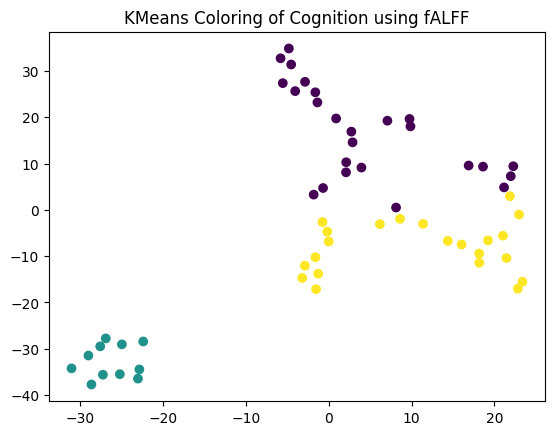

In [474]:

X_pca_tsne = tsne.fit_transform(X_pca)
plt.title("KMeans Coloring of Cognition using fALFF")

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=kmeans.labels_, cmap="viridis")
plt.show()


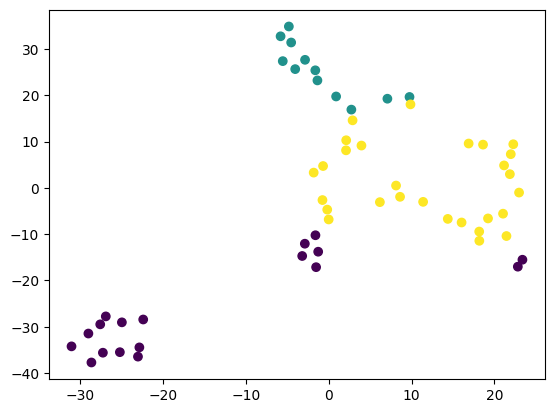

In [459]:
plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=gmm_y, cmap="viridis")

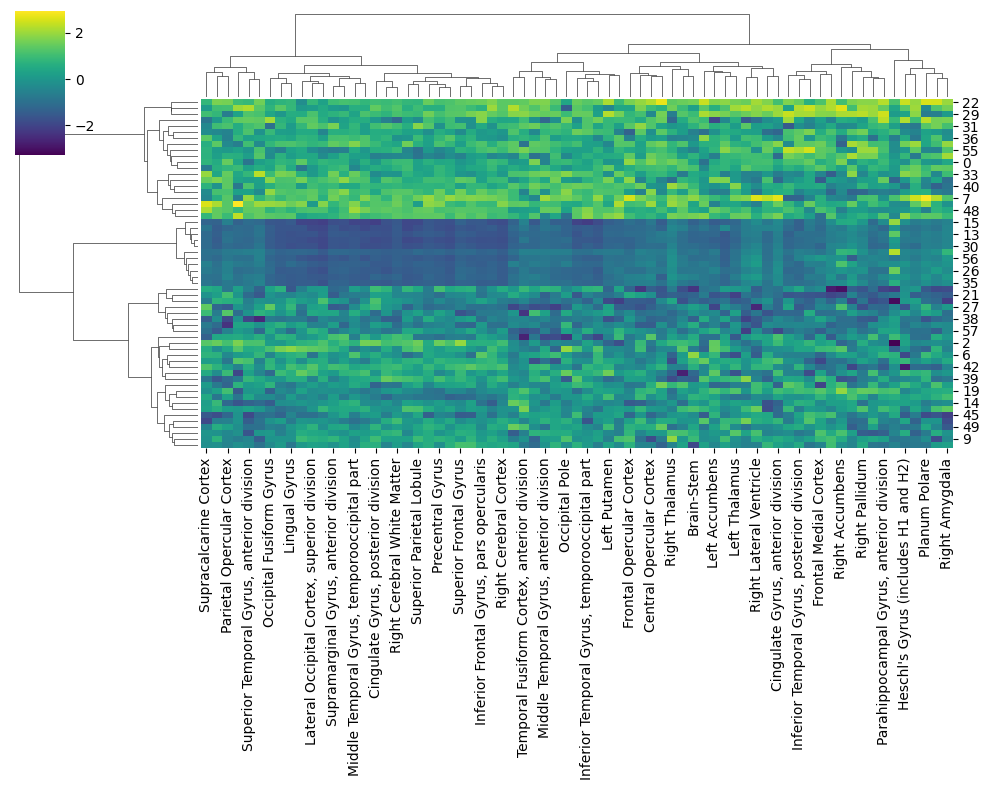

In [463]:
from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt

# Compute hierarchical linkage matrix
Z = linkage(fALFF_df_scaled_imputed, method="ward")  # "ward" minimizes intra-cluster variance

# Assign 3 clusters based on tree cut
df["Cluster"] = fcluster(Z, 3, criterion="maxclust")
y = df["Cluster"]

# Visualize dendrogram
sns.clustermap(fALFF_df_scaled_imputed, method="ward", cmap="viridis", figsize=(10, 8))
plt.show()


In [493]:
X_pca = pca.fit_transform(cv_df_scaled_imputed.loc[:, DMN])
tsne = TSNE(perplexity=5)
X_pca_tsne = tsne.fit_transform(X_pca)

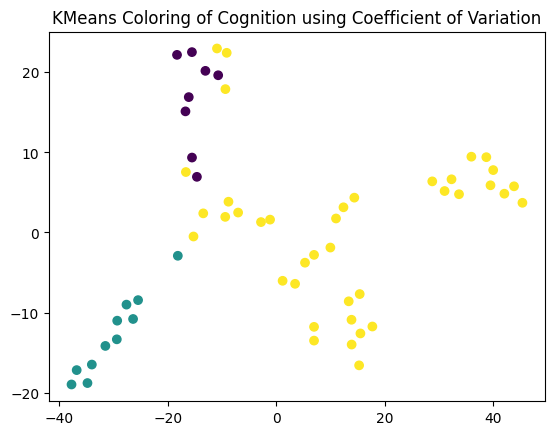

In [494]:
plt.title("KMeans Coloring of Cognition using Coefficient of Variation")

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=kmeans_cv_y, cmap="viridis")
plt.show()

### Feature Importance & ANOVA Testing

In [471]:
anova_f, anova_p = f_classif(fALFF_df_scaled_imputed.loc[:, DMN], kmeans_y)
anova_results = pd.DataFrame({"Feature": fALFF_df_scaled_imputed.loc[:, DMN].columns, "F-Score": anova_f, "p-Value": anova_p})
anova_results = anova_results.sort_values(by="F-Score", ascending=False)
print("ANOVA Results:\n", anova_results.head(10))


ANOVA Results:
                                       Feature    F-Score       p-Value
1                           Precuneous Cortex  83.373003  2.233260e-17
2                               Angular Gyrus  61.903369  8.306484e-15
4         Cingulate Gyrus, posterior division  44.568221  3.116696e-12
5    Parahippocampal Gyrus, anterior division  31.751975  6.797063e-10
7                      Frontal Orbital Cortex  27.956056  4.198094e-09
12                     Substantia Nigra Right  24.597910  2.339327e-08
6   Parahippocampal Gyrus, posterior division  23.030667  5.418582e-08
0                                Frontal Pole  22.690536  6.524523e-08
8                            Left Hippocampus  18.098651  9.129968e-07
9                           Right Hippocampus  16.841220  1.969876e-06


In [472]:
kmeans_cv =  KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_cv_y = kmeans_cv.fit_predict(cv_df_scaled_imputed)


In [473]:
anova_f, anova_p = f_classif(cv_df_scaled_imputed.loc[:, DMN], kmeans_cv_y)
anova_results = pd.DataFrame({"Feature": cv_df_scaled_imputed.loc[:, DMN].columns, "F-Score": anova_f, "p-Value": anova_p})
anova_results = anova_results.sort_values(by="F-Score", ascending=False)
print("ANOVA Results:\n", anova_results.head(10))


ANOVA Results:
                                      Feature     F-Score       p-Value
1                          Precuneous Cortex  115.219719  2.154466e-20
4        Cingulate Gyrus, posterior division  113.317603  3.115896e-20
3         Cingulate Gyrus, anterior division   67.415485  1.602801e-15
8                           Left Hippocampus   65.331485  2.951403e-15
6  Parahippocampal Gyrus, posterior division   57.746929  3.075981e-14
2                              Angular Gyrus   51.606620  2.403235e-13
7                     Frontal Orbital Cortex   43.676394  4.389445e-12
9                          Right Hippocampus   25.930079  1.168259e-08
0                               Frontal Pole   17.910811  1.022750e-06
5   Parahippocampal Gyrus, anterior division   17.186771  1.591209e-06


In [497]:
missing_columns

['participant_id', 'age', 'sex', 'years_of_education']

In [498]:
p_imputed_df.drop(missing_columns, axis=1)

,handedness,attention,executive,global,language,memory,visuospatial,moca_total,drs,tmt_a,tmt_b,bta,sdmt_oral,bnt,cvlt15,cvlt_ld_tot,fas,jlo
0,3.0,0.74333,0.08219,-0.12135,0.58319,-1.26360,-0.181613,23.0,133.0,27.82,159.49,19.0,38.0,59.0,17.0,1.0,39.0,25.0
1,2.0,0.22898,-0.72817,0.25027,-0.24200,-0.66063,-0.377471,25.0,136.0,59.25,301.23,16.0,25.0,52.0,27.0,3.0,42.0,24.0
2,3.0,0.18272,0.18931,0.41475,-0.36043,0.95818,-0.769186,26.0,137.0,51.38,161.55,14.0,44.0,56.0,43.0,12.0,20.0,22.0
3,3.0,0.35645,0.12266,0.29293,-0.25917,0.61895,-2.923620,25.0,137.0,34.50,144.40,14.0,37.0,57.0,37.0,11.0,19.0,11.0
4,3.0,0.30705,0.00481,-0.15784,-1.18563,0.46936,0.601817,22.0,135.0,39.30,169.34,14.0,36.0,49.0,42.0,8.0,23.0,29.0
5,3.0,0.62534,0.96298,1.02999,0.33756,0.43116,1.385247,30.0,140.0,26.92,58.23,17.0,63.0,56.0,38.0,9.0,44.0,33.0
6,3.0,0.45892,0.41552,0.32941,0.61332,0.58259,0.210102,26.0,135.0,43.09,99.50,17.0,43.0,57.0,45.0,8.0,49.0,27.0
7,2.0,0.61256,0.93263,0.62807,0.30847,0.61987,1.189390,26.0,142.0,21.98,56.19,16.0,61.0,56.0,43.0,9.0,43.0,32.0
8,3.0,-0.46109,-0.21207,-0.11517,0.91712,-0.36007,0.405959,22.0,136.0,70.66,175.60,7.0,26.0,60.0,26.0,6.0,46.0,28.0
9,3.0,0.37088,0.45054,0.74989,-0.37550,-0.02038,0.601817,27.0,142.0,39.28,85.79,15.0,42.0,57.0,35.0,6.0,15.0,29.0
